# Fine-tuning Gemma for Mobile Deployment

This notebook demonstrates the process of fine-tuning a large language model (LLM), using **Gemma 2** as an example, for a non-English language.  It then covers the conversion of the fine-tuned model to the `.gguf` format, enabling its deployment and usage on mobile devices. Finally, the notebook presents examples of the model running on a mobile phone.



## Gemma: An Open-Source Language Model by Google

[**Gemma**](https://ai.google.dev/gemma#gemma-2), developed by **Google**, is an open-source model focused on text understanding and generation.  Its capabilities enable advanced natural language processing (NLP) tasks, including:

* Text summarization
* Translation
* Creative writing

Gemma is available in various sizes, offering flexibility for developers to select the model that best aligns with their computational resources and target applications.  This powerful and accessible tool is designed for researchers and developers working on text-focused AI projects.

### Why Choose Gemma?

Google's Gemma prioritizes safety, efficiency, and performance in AI development. Key advantages include:

* **Safety:** Trained on a carefully curated and rigorously filtered dataset to minimize harmful content and reduce toxic output.
* **Efficiency:**  Its smaller size facilitates controlled experimentation and faster refinement of safety protocols.
* **Performance:**  Gemma demonstrates strong performance in tasks like reasoning, mathematics, and code generation, while outperforming competitors in safety and efficiency.

Learn more in this [article](https://medium.com/p/37385f8cd20a).

## Fine-tuning Gemma 2 for Greek Text

This notebook demonstrates fine-tuning a pre-trained Gemma 2 Transformer model for Greek text. [Transformers](https://aws.amazon.com/what-is/transformers-in-artificial-intelligence/) are a neural network architecture designed for sequential data. They learn contextual relationships within text to perform various NLP tasks, such as translation and summarization.

We fine-tune the model using a translated dataset.  For demonstration purposes, we use Google Translate. However, you can adapt the dataset to your target language using any preferred machine translation service. The included translation cells simplify this process, allowing easy customization of the training data.

## Preparation
Install and import libraries

In [ ]:
# Install necessary liraries
!pip install transformers accelerate datasets peft trl bitsandbytes --quiet
!pip install googletrans==4.0.0-rc1 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.4/293.4 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
# Log in to HF to download the Gemma 2 model and upload yours when you finish the fine-tuning
from huggingface_hub import login
hf_token = "" # Your HF token here
login(token=hf_token)

In [ ]:
from peft import PeftModel, LoraConfig
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, LlamaTokenizer, TrainingArguments, DataCollatorForSeq2Seq
from trl import SFTTrainer
import json

from googletrans import Translator ## 113 languages available. Read at https://readthedocs.org/projects/py-googletrans/downloads/pdf/latest/

from datasets import Dataset, DatasetDict, load_dataset

## For the fine-tuning procedure we used the Alpaca Dataset

The **Alpaca dataset** is a substantial collection of **52,000** instruction-demonstration pairs generated by OpenAI's text-davinci-003 engine, designed to improve the instruction-following capabilities of language models.<sup>[1]</sup> This dataset is a crucial resource for instruction tuning, enabling models to better respond to user commands and queries.

Alpaca comprises a diverse range of programming tasks and their corresponding instructions, representing various use cases in AI and machine learning.  Key features include:

* **Multiple Programming Languages:** Includes languages like Python and JavaScript, exposing models to diverse syntactic structures and paradigms.<sup>[2]</sup>
* **Varying Complexity:** Tasks range from simple function definitions to complex algorithm implementations, catering to different skill levels.<sup>[3]</sup>

Data preprocessing is essential for preparing the Alpaca dataset for training. This involves addressing real-world data issues like inconsistencies and missing values, which can significantly impact model performance.<sup>[3][4]</sup> Techniques such as normalization, scaling, and feature engineering improve data quality and usability.  Validating the processed data ensures it meets the model's requirements, mitigating overfitting risks and enhancing overall accuracy.<sup>[3][5]</sup>

In summary, the Alpaca dataset is a comprehensive resource for training AI models, especially for instruction-following tasks, contributing significantly to advancements in natural language processing.

---

[1]: [Datasets at Hugging Face](https://huggingface.co/datasets/tatsu-lab/alpaca)
[2]: [Data processing](https://www.appliedaicourse.com/blog/data-preprocessing-in-machine-learning/)
[3]: [Data Preprocessing in Machine Learning: Steps, Techniques](https://www.appliedaicourse.com/blog/data-preprocessing-in-machine-learning/)
[4]: [Data Preprocessing Techniques in Machine Learning](https://www.scalablepath.com/data-science/data-preprocessing-phase)
[5]: [Fine-Tuning CodeAlpaca Dataset - Restackio](https://www.restack.io/p/fine-tuning-answer-codealpaca-dataset-cat-ai)

In [ ]:
# Download the english version of the alpaca dataset
!wget https://huggingface.co/datasets/yahma/alpaca-cleaned/resolve/main/alpaca_data_cleaned.json

# In case you want to download directly the greek dataset and do not do the translation procedure, uncomment one of the below lines
#!wget https://huggingface.co/datasets/gsoloupis/gemma_greek_1000/resolve/main/greek_output_1000.json
# or
#!wget https://huggingface.co/datasets/gsoloupis/alpaca_greek_10000/resolve/main/alpaca_greek_10000.json

--2025-01-10 04:30:00--  https://huggingface.co/datasets/yahma/alpaca-cleaned/resolve/main/alpaca_data_cleaned.json
Resolving huggingface.co (huggingface.co)... 18.164.174.23, 18.164.174.55, 18.164.174.118, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.23|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/fe/53/fe53a08b15e8e51c190c06edcd9c81cf658787c1a704c684331a232a8ce08d80/bd844b8247a0f543804b6ce0882b0aaec4bbf5e8d66167df6213a0f1e4fe878b?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27alpaca_data_cleaned.json%3B+filename%3D%22alpaca_data_cleaned.json%22%3B&response-content-type=application%2Fjson&Expires=1736742601&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczNjc0MjYwMX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy9mZS81My9mZTUzYTA4YjE1ZThlNTFjMTkwYzA2ZWRjZDljODFjZjY1ODc4N2MxYTcwNGM2ODQzMzFhMjMyYThjZTA4ZDgwL2JkODQ0YjgyNDdhMGY1NDM4MDRiNmNlMDg4MmIw

In [ ]:
# The training here was performed with 1000 examples and the output is pretty good.
# You can adjust to 10000 or more depend on your preferences.

def save_first_n_json(input_file, output_file, n=1000):
    """Loads a JSON file, extracts the first n entries, and saves them to a new JSON file.

    Args:
        input_file: Path to the input JSON file.
        output_file: Path to the output JSON file.
        n: The number of entries to extract. Defaults to 1000.
    """
    try:
        with open(input_file, 'r', encoding='utf-8') as f_in:  # Add encoding for robustness
            data = json.load(f_in)

        if not isinstance(data, list):  # Check if the JSON data is a list
            raise TypeError("The JSON data must be a list.")


        if len(data) < n:
            print(f"Warning: The input file has fewer than {n} entries. Saving all available entries.")
            first_n = data
        else:
            first_n = data[:n]

        with open(output_file, 'w', encoding='utf-8') as f_out:
            json.dump(first_n, f_out, indent=4, ensure_ascii=False)  # Use indent for pretty printing and ensure_ascii for proper UTF-8 handling

        print(f"Successfully saved the first {len(first_n)} entries to {output_file}")

    except FileNotFoundError:
        print(f"Error: Input file '{input_file}' not found.")
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in '{input_file}'.")
    except TypeError as e:
        print(f"Error: {e}")

input_file = '/content/alpaca_data_cleaned.json'
output_file = 'output1000.json'
num_entries = 1000

save_first_n_json(input_file, output_file, num_entries)

In [ ]:
# Just for illustration
# Use it to print the generated .json file

def print_json_file(file_path):
    """Prints the contents of a JSON file in a formatted way and displays the number of objects.

    Args:
        file_path: The path to the JSON file.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        # Pretty print with indentation (more readable)
        print(json.dumps(data, indent=4))

        # Count the number of objects
        if isinstance(data, list):
            print(f"Number of objects: {len(data)}")
        elif isinstance(data, dict):
            print(f"Number of key-value pairs: {len(data)}")
        else:
            print("The JSON root is neither a list nor a dictionary.")

    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in '{file_path}'.")

# Example usage
print_json_file('greek_output_1000.json')

## Translation Implementation

The translation process is implemented in the code below.  Refer to [this document](https://readthedocs.org/projects/py-googletrans/downloads/pdf/latest/) for further information and to explore the language codes (page 17).

In [ ]:
###########################################################
# Just change 'el' below to your preference language code #
###########################################################

def translate_json_file(input_file, output_file, target_language='el'):

    """Translates the 'output', 'input', and 'instruction' fields of each
       JSON object in a file to the target language.

    Args:
        input_file: Path to the input JSON file.
        output_file: Path to the output JSON file.
        target_language: The target language code (e.g., 'el' for Greek).
    """
    try:
        with open(input_file, 'r', encoding='utf-8') as f_in:
            data = json.load(f_in)

        translator = Translator()

        for item in data:
            for key in ["output", "input", "instruction"]:  # Iterate through the keys to translate
                if key in item:
                    try:
                        translated = translator.translate(item[key], dest=target_language)
                        item[key] = translated.text
                    except Exception as e:
                        print(f"Warning: Translation error for key '{key}' in item: {item.get('instruction', '')[:50]}... Error: {e}")


        with open(output_file, 'w', encoding='utf-8') as f_out:
            json.dump(data, f_out, indent=4, ensure_ascii=False)

        print(f"Translation complete. Saved to {output_file}")

    except FileNotFoundError:
        print(f"Error: Input file '{input_file}' not found.")
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in '{input_file}'.")

input_file = 'output1000.json'
output_file = 'greek_output_1000.json'

# Translates the input json file to your preference language.
# Keys stay the same. Values are translated.
translate_json_file(input_file, output_file)

##Parameters and model loading

We use Lora for fine-tuning

**LoRA** (**Low-Rank Adaptation**) of **Large Language Models (LLMs)** is a powerful technique for **fine-tuning** LLMs efficiently. Instead of updating all the model's parameters, LoRA **freezes** the pre-trained weights and injects trainable **rank decomposition matrices** into each layer of the **Transformer** architecture. This significantly reduces the number of trainable parameters, leading to **faster training**, **lower memory requirements**, and often comparable or even better **performance** compared to full fine-tuning. LoRA also simplifies **sharing and combining** learned adaptations, making it a valuable tool for adapting LLMs to specific tasks or domains.

In [ ]:
# Configure Lora parameters
lora_config = LoraConfig(
    r=32,  # Rank of the low-rank matrices. Smaller values lead to faster inference and smaller model size, but potentially reduced performance.  32 is a common starting point.
    lora_alpha=32,  # Scaling factor applied to the merged LoRA weights.  Often set equal to `r`.  Affects the learning rate scaling of the LoRA parameters.
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],  # Names of the modules within the transformer architecture to apply LoRA to.  These typically represent the projection matrices within attention and feedforward layers.  Choosing appropriate target modules is crucial for effective LoRA training.
    task_type="CAUSAL_LM",  # Specifies the type of task being performed. This helps in configuring appropriate biases and optimizations for specific task types. "CAUSAL_LM" indicates causal language modeling (like text generation).
)

In [ ]:
# Adding B&B configuration for training creates an issue when you try to convert to GGUF format.
# Use if you only need to train and inference here and not proceed to mobile deployment.
'''
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,  # Use 8-bit quantization
    bnb_8bit_quant_type="nf8", # Use nf8 for better quality
    #bnb_8bit_compute_dtype=torch.bfloat16 # Use bfloat16 if available #### or float16
)

OR

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
    #Use fp16 for not supported bf16 hardware
    #bnb_4bit_compute_dtype=torch.float16
)
'''


In [ ]:
# Download the model from Hugging Face.
modelName = "google/gemma-2-2b-it" # google/gemma-2-2b-it or google/gemma-2-2b

eval_tokenizer = AutoTokenizer.from_pretrained(modelName, token=hf_token)
base_model = AutoModelForCausalLM.from_pretrained(modelName,
                                             #quantization_config=bnb_config, # See above for B&B explanation
                                             device_map="auto",
                                             token=hf_token)

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

## Pre-processing steps

In [ ]:
# Creating Gemma prompt based on the model card.
# https://huggingface.co/google/gemma-2-2b-it
gemma_prompt = """<start_of_turn>user
{}: {}<end_of_turn>
<start_of_turn>model
{}<end_of_turn>"""

eos_token = eval_tokenizer.eos_token
pad_token = eval_tokenizer.pad_token
eval_tokenizer.padding_side = "right"

eos_token, pad_token

('<eos>', '<pad>')

In [ ]:
# Convert to Gemma format
def convert_json_to_gemma_format(json_file_path, gemma_prompt):
    """Converts a JSON file to the Gemma format.

    Args:
        json_file_path: Path to the JSON file.
        gemma_prompt: The Gemma prompt template string.

    Returns:
        A dictionary containing the formatted text data.
    """
    with open(json_file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    texts = []
    for item in data:
        instruction = item.get("instruction", "")
        input_text = item.get("input", "") # Using input_text to avoid shadowing built-in 'input'
        output = item.get("output", "")
        text = gemma_prompt.format(instruction, input_text, output) + eos_token
        texts.append(text)

    return {"text": texts}

json_file_path = "/content/greek_output_1000.json"

gemma_data = convert_json_to_gemma_format(json_file_path, gemma_prompt)

In [ ]:
# Calculate split sizes
total_samples = len(gemma_data["text"])
print("Total samples:", total_samples)
train_size = int(0.9 * total_samples)
val_size = total_samples - train_size

# Create Dataset objects for the splits
dataset_train = Dataset.from_dict({"text": gemma_data["text"][:train_size]})
dataset_val = Dataset.from_dict({"text": gemma_data["text"][train_size:]})

dataset_train, dataset_train[0]

Total samples: 1000


(Dataset({
     features: ['text'],
     num_rows: 900
 }),
 {'text': '<start_of_turn>user\nΔώστε τρεις συμβουλές για να παραμείνετε υγιείς.: <end_of_turn>\n<start_of_turn>model\n1. Τρώτε μια ισορροπημένη και θρεπτική διατροφή: Βεβαιωθείτε ότι τα γεύματά σας περιλαμβάνουν μια ποικιλία από φρούτα και λαχανικά, άπαχο πρωτεΐνη, δημητριακά ολικής αλέσεως και υγιή λίπη.Αυτό βοηθά στην παροχή στο σώμα σας με τα απαραίτητα θρεπτικά συστατικά για να λειτουργήσει στο καλύτερο δυνατό και μπορεί να βοηθήσει στην πρόληψη χρόνιων ασθενειών.\n\n2. Συμμετέχετε σε τακτική σωματική δραστηριότητα: Η άσκηση είναι ζωτικής σημασίας για τη διατήρηση ισχυρών οστών, μυών και καρδιαγγειακής υγείας.Στόχος για τουλάχιστον 150 λεπτά μέτριας αερόβιας άσκησης ή 75 λεπτά έντονης άσκησης κάθε εβδομάδα.\n\n3. Πάρτε αρκετό ύπνο: Να πάρει αρκετό ποιοτικό ύπνο είναι ζωτικής σημασίας για τη σωματική και ψυχική ευεξία.Βοηθά στη ρύθμιση της διάθεσης, στη βελτίωση της γνωστικής λειτουργίας και στη στήριξη της υγιούς ανάπτυξη

In [ ]:
# Tokenize the datasets
def tokenize_function(examples):
    tokenized = eval_tokenizer(
        examples["text"],  # The input text data from the dataset.  Assumes the dataset has a column named "text".
        padding="max_length",  # Pad all sequences to the same length (specified by max_length).  This is crucial for batching.
        truncation=True,  # Truncate sequences longer than max_length.  Essential to avoid out-of-memory errors.
        max_length=256,  # The maximum sequence length.  Longer sequences allow for more context but increase memory usage.
        return_tensors="pt"  # Return PyTorch tensors. Required for training with PyTorch.
    )
    # Labels are identical to input_ids for causal language modeling
    tokenized["labels"] = tokenized["input_ids"].clone() # In causal LM, the model predicts the next token.  The labels are the same as the input, shifted by one position.  This line creates the labels.
    return tokenized

print("Tokenizing dataset...")
dataset_train = dataset_train.map(tokenize_function, batched=True, remove_columns=["text"])
dataset_val = dataset_val.map(tokenize_function, batched=True, remove_columns=["text"])
print("Dataset tokenized:", dataset_train[0])

Tokenizing dataset...


Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Dataset tokenized: {'input_ids': [2, 106, 1645, 108, 236818, 236335, 45010, 3761, 235546, 60980, 172742, 4796, 194978, 22889, 17748, 62739, 235603, 16525, 34794, 10491, 31346, 110360, 117996, 5672, 235248, 107, 108, 106, 2516, 108, 235274, 235265, 24919, 42228, 10491, 63162, 94992, 63805, 10180, 78889, 95929, 11508, 21067, 26994, 235600, 57521, 40068, 66420, 99778, 235292, 48466, 233957, 6386, 235897, 73169, 10491, 62900, 24787, 114479, 236078, 11761, 21914, 75971, 64761, 188232, 21028, 29578, 63162, 68529, 7755, 118614, 12276, 23924, 20982, 79247, 9221, 11508, 125951, 133817, 45349, 235269, 51946, 35033, 108225, 124286, 10491, 242016, 27084, 235269, 76784, 44729, 235476, 67006, 78885, 13839, 235651, 93139, 6073, 46785, 28195, 28672, 11508, 31346, 110360, 235943, 151062, 78889, 235265, 236318, 137652, 174167, 235628, 236051, 235769, 40609, 25943, 10180, 91812, 24692, 5891, 236335, 11761, 75971, 14765, 24787, 193859, 10168, 235730, 76713, 21067, 26994, 235600, 53462, 24473, 71423, 53462

##Training

In [ ]:
# Training arguments
# Adjust per your needs and how powerful your working environment is
train_args = TrainingArguments(
    per_device_train_batch_size=4,  # Each GPU processes 4 examples per step.
    gradient_accumulation_steps=1,  # Gradients are accumulated over 1 step before updating weights.
    warmup_steps=30,  # Learning rate warms up (gradually increases) for the first 30 steps.
    max_steps=1000,  # Total number of optimization steps for training.
    # num_train_epochs=3,  # Not used because `max_steps` defines the training duration.
    gradient_checkpointing=True,  # Saves memory by recomputing activations during backpropagation.
    learning_rate=3e-4,  # Base learning rate for the optimizer.
    fp16=False,  # FP16 precision is disabled (not used).
    bf16=False,  # Enables bfloat16 precision, optimized for RTX 4090 GPUs. # True creates more stable outputs on mobile
    logging_steps=20,  # Logs training metrics every 20 steps.
    optim="adamw_8bit",  # Uses AdamW optimizer with 8-bit precision for optimizer states to save memory.
    weight_decay=0.01,  # Regularization to prevent overfitting by penalizing large weights.
    lr_scheduler_type="linear",  # Linearly decays learning rate after the warmup period.
    output_dir="outputs",  # Directory where model checkpoints and logs will be saved.
    report_to="none",  # Disables logging to external tools like TensorBoard or WandB.
    #evaluation_strategy="steps", # Evaluation is performed every eval_steps
    #eval_steps=80  # Evaluate every 80 steps
)

# If you need to see the evaluation during training and you run to this error
# https://huggingface.co/google/gemma-2-9b/discussions/24
# use below
# base_model.to(torch.bfloat16)

In [ ]:
# Define a data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=eval_tokenizer,
    model=base_model,
    padding="longest",
    return_tensors="pt"
)

# Create the trainer
trainer = SFTTrainer(
    model=base_model,
    tokenizer=eval_tokenizer,
    args=train_args,
    peft_config=lora_config,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
    data_collator=data_collator
    )

trainer.train()

<ipython-input-11-5707dfe43d81>:10: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
20,7.299100
40,1.592100
60,1.071900
80,1.053900
100,0.822300
120,0.884900
140,0.883400
160,0.914400
180,0.867600
200,0.851900


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


TrainOutput(global_step=1000, training_loss=0.5739955449104309, metrics={'train_runtime': 2162.7633, 'train_samples_per_second': 1.849, 'train_steps_per_second': 0.462, 'total_flos': 1.2693819359232e+16, 'train_loss': 0.5739955449104309, 'epoch': 4.444444444444445})

In [ ]:
trainer.save_model("trainer_gemma_2_2b")

##Save model

In [ ]:
# Load your fine-tuned model
ft_model = PeftModel.from_pretrained(base_model, "trainer_gemma_2_2b")

# Merge adapters with the base model
merged_model = ft_model.merge_and_unload()

# Save the merged model to a directory
output_dir = "/content/merged_model"
merged_model.save_pretrained(output_dir)
eval_tokenizer.save_pretrained(output_dir)

('/content/merged_model/tokenizer_config.json',
 '/content/merged_model/special_tokens_map.json',
 '/content/merged_model/tokenizer.model',
 '/content/merged_model/added_tokens.json',
 '/content/merged_model/tokenizer.json')

##Push to HF

In [ ]:
# HuggingFace repository ID
repo_id = f"gsoloupis/gemma2_2B_it_greek_full_32"

# Push the model and tokenizer to HuggingFace Hub
merged_model.push_to_hub(repo_id, token=True, max_shard_size="5GB", safe_serialization=True)
eval_tokenizer.push_to_hub(repo_id, token=True)

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/481M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/gsoloupis/gemma2_2B_it_greek_full_32/commit/565b5307e91f73fe2c652678ad87e5753df483d4', commit_message='Upload tokenizer', commit_description='', oid='565b5307e91f73fe2c652678ad87e5753df483d4', pr_url=None, repo_url=RepoUrl('https://huggingface.co/gsoloupis/gemma2_2B_it_greek_full_32', endpoint='https://huggingface.co', repo_type='model', repo_id='gsoloupis/gemma2_2B_it_greek_full_32'), pr_revision=None, pr_num=None)

## Evaluation

Use the cells below to run inference and evaluate the model. The primary goal of this notebook is to train the Gemma model and deploy it on an Android device.  All inference examples, including mobile screenshots comparing Gemma with and without fine-tuning, are provided at the end of the notebook.

In [ ]:

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Replace with the exact path
path = "gsoloupis/gemma2_2B_it_greek_full_32"

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(path, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(path, device_map="auto", trust_remote_code=True)

# Example usage: generate text
prompt = "what is an airport?"
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)

with torch.no_grad():
  generated_ids = model.generate(input_ids, max_new_tokens=256, do_sample=True, temperature=0.7, top_p=0.05)

generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print(generated_text)

##Conversion to gguf

Use below OR go to https://huggingface.co/spaces/ggml-org/gguf-my-repo

In [ ]:
!git clone https://github.com/ggerganov/llama.cpp.git

Cloning into 'llama.cpp'...
remote: Enumerating objects: 40388, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 40388 (delta 52), reused 17 (delta 17), pack-reused 40303 (from 4)
Receiving objects: 100% (40388/40388), 71.20 MiB | 25.71 MiB/s, done.
Resolving deltas: 100% (29287/29287), done.


In [ ]:
!pip install -r llama.cpp/requirements.txt

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu, https://download.pytorch.org/whl/cpu, https://download.pytorch.org/whl/cpu, https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.8/186.8 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1+cu121
    Uninstalling torch-2.5.1+cu121:
      Successfully uninstalled torch-2.5.1+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.5.1+cu121 requires torch==2.5.1, but you have torch 2.2.2+cpu which is incompatible.
torchvision 0.20.1+cu121 requires torch==2.5.1, but you have torch 2.2.2+cpu which is incompatible.


In [ ]:
!python llama.cpp/convert_hf_to_gguf.py -h

In [ ]:
!python llama.cpp/convert_hf_to_gguf.py /content/merged_model \
  --outfile gemma_greek_2_2b_it_q8_0.gguf \
  --outtype q8_0

INFO:hf-to-gguf:Loading model: merged_model
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:gguf: loading model weight map from 'model.safetensors.index.json'
INFO:hf-to-gguf:gguf: loading model part 'model-00001-of-00003.safetensors'
INFO:hf-to-gguf:token_embd.weight,                 torch.float32 --> Q8_0, shape = {2304, 256000}
INFO:hf-to-gguf:blk.0.attn_norm.weight,            torch.float32 --> F32, shape = {2304}
INFO:hf-to-gguf:blk.0.ffn_down.weight,             torch.float32 --> Q8_0, shape = {9216, 2304}
INFO:hf-to-gguf:blk.0.ffn_gate.weight,             torch.float32 --> Q8_0, shape = {2304, 9216}
INFO:hf-to-gguf:blk.0.ffn_up.weight,               torch.float32 --> Q8_0, shape = {2304, 9216}
INFO:hf-to-gguf:blk.0.post_attention_norm.weight,  torch.float32 --> F32, shape = {2304}
INFO:hf-to-gguf:blk.0.post_ffw_norm.weight,        torch.float32 --> F32, shape = {2304}
INFO:hf-to-gguf:blk.0.ffn_norm.weight,  

## Deploying the .gguf Model on Android

The `.gguf` model can be downloaded and used within an Android application.  You can build an Android app for this purpose, for example, using [this project](https://github.com/shubham0204/SmolChat-Android) as a reference.

## Inference and evaluation on the mobile

Gemma **before** fine-tuning with a question "What is a museum" in greek.

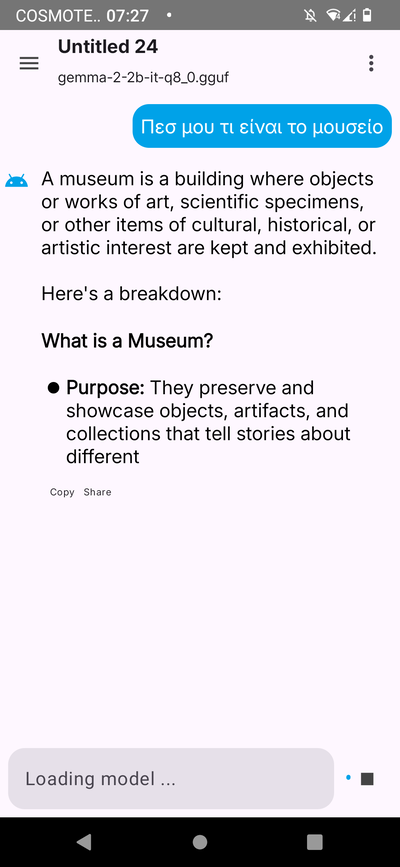

Gemma **fine-tuned** with a question in greek. The question is "What is a museum"

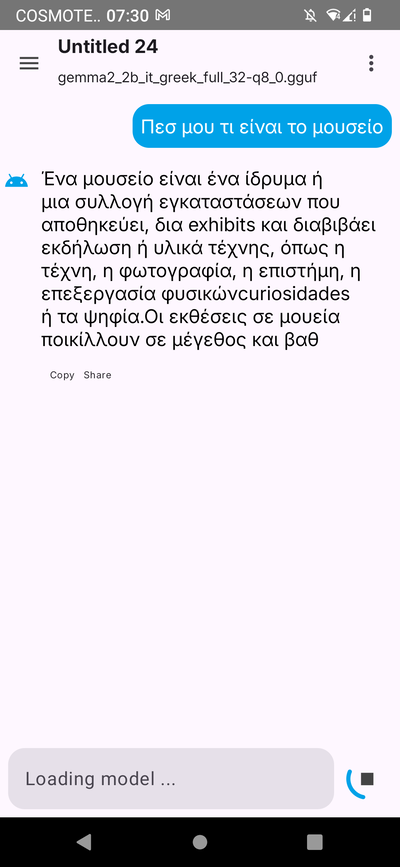

Gemma before fine-tuning with a storrytelling about a cat. The output makes no sense in greek.

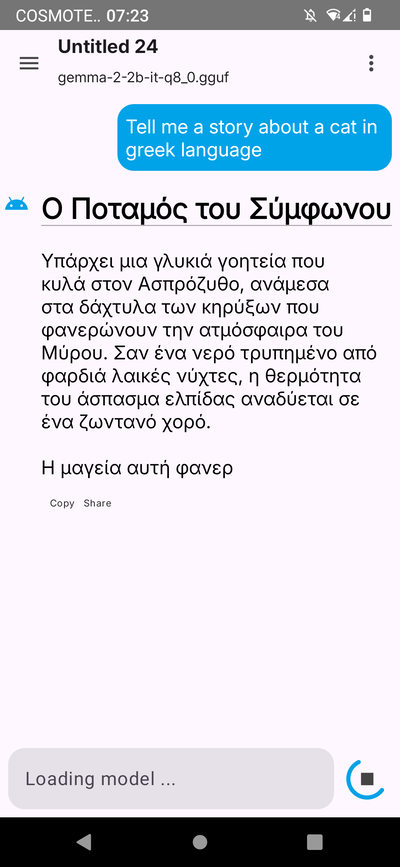

Gemma fine-tuned with a storrytelling about a cat.

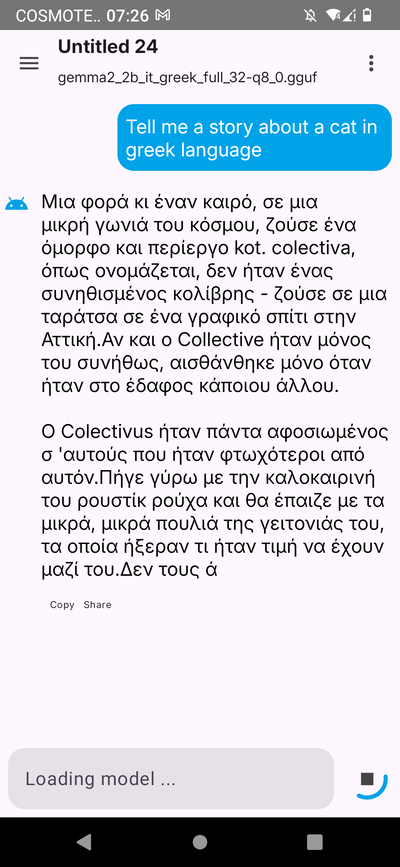

Gemma before fine-tuning with a translation example

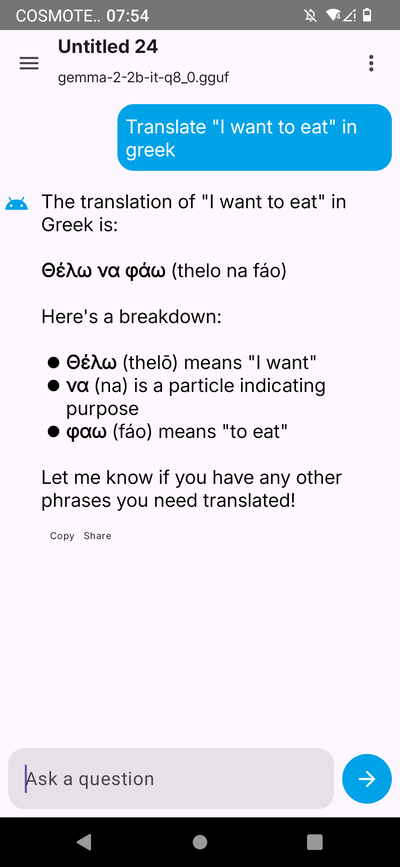

Gemma after fine-tuning with a translation example

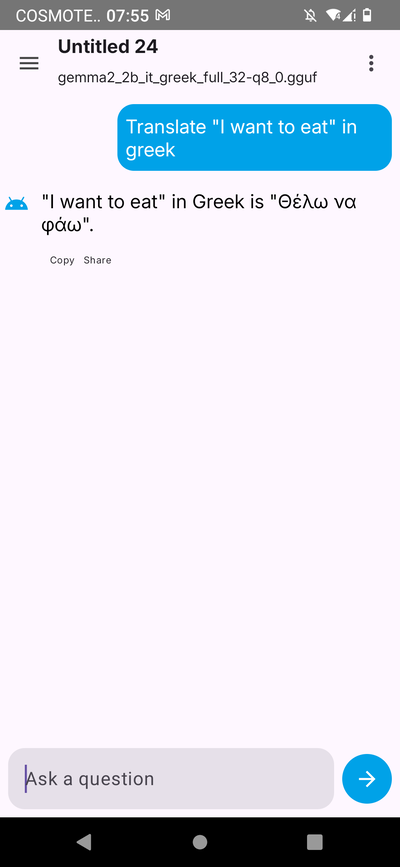

Gemma before fine-tuning for a summary task. It responds back in english despite prompted to respond in greek.

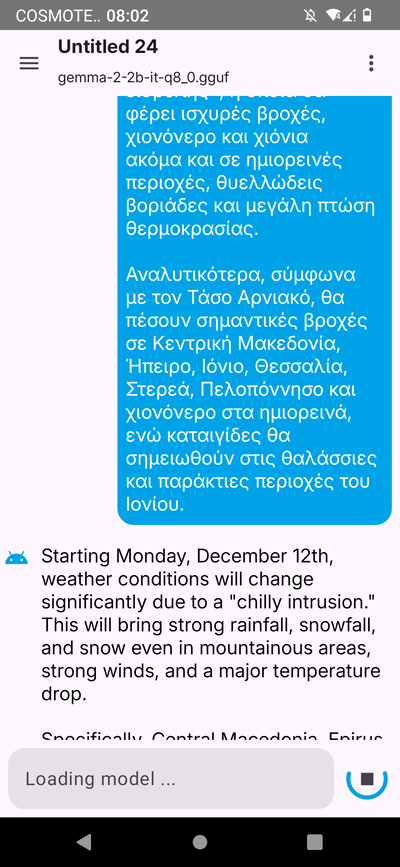

Gemma after fine-tuning. Responds in greek.

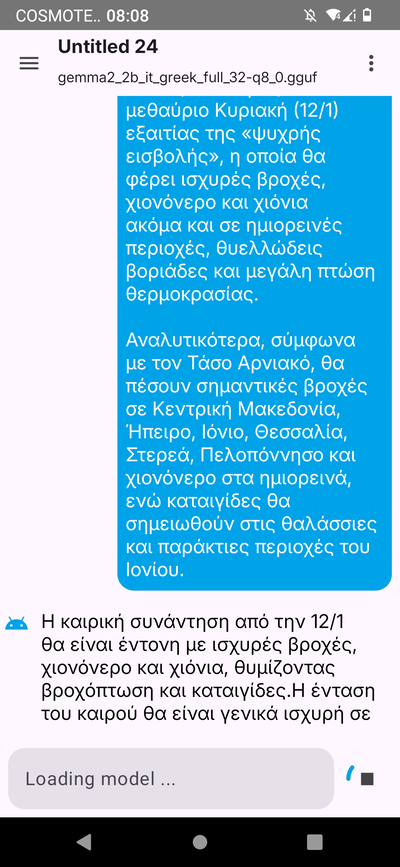

Gemma before fine-tuning to explain a poem. It responds back in english despite it is prompted to do in greek.

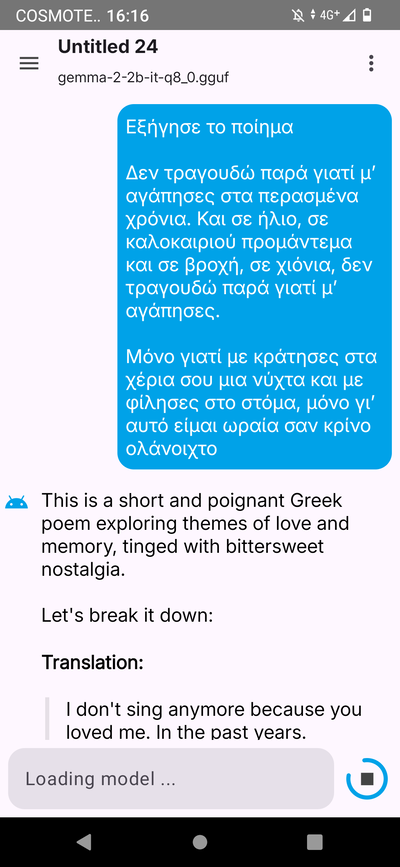

Gemma after fine-tunning it explains the poem in Greek.

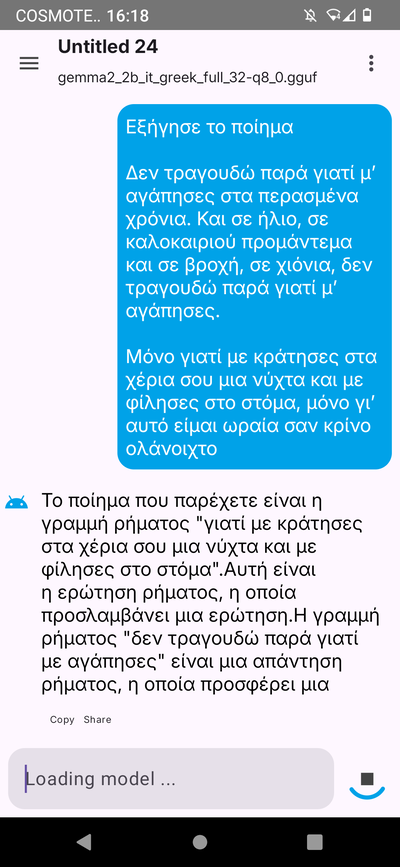